In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot

import pandas as pd
import numpy as np
import datetime as dt
from collections import defaultdict
import time
import datetime as dt
from pytz import timezone
tz = timezone('EST')
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
sns.set()

In [2]:
nh2011 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2011_smd_hourly.xls")
nh2011 = pd.read_excel(nh2011, 'NH')
nh2012 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2012_smd_hourly.xls")
nh2012 = pd.read_excel(nh2012, 'NH')
nh2013 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2013_smd_hourly.xls")
nh2013 = pd.read_excel(nh2013, 'NH')
nh2014 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2014_smd_hourly.xls")
nh2014 = pd.read_excel(nh2014, 'NH')
nh2015 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2015_smd_hourly.xls")
nh2015 = pd.read_excel(nh2015, 'NH')
nh2016 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2016_smd_hourly.xls")
nh2016 = pd.read_excel(nh2016, 'NH')

In [3]:
nh2017 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2017_smd_hourly.xlsx", 'NH')
nh2018 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2018_smd_hourly.xlsx", 'NH')
nh2019 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2019_smd_hourly.xlsx", 'NH')
nh2020 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2020_smd_hourly.xlsx", 'NH')
nh2021 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2021_smd_hourly.xlsx", 'NH')
nh2022 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2022_smd_hourly.xlsx", 'NH')

In [4]:
nh2022

,Date,Hr_End,DA_Demand,RT_Demand,DA_LMP,DA_EC,DA_CC,DA_MLC,RT_LMP,RT_EC,RT_CC,RT_MLC,Dry_Bulb,Dew_Point
0,2022-01-01,1,1005.6,1042.181,32.93,32.35,0.10,0.48,26.38,25.95,0.0,0.43,34,34
1,2022-01-01,2,985.4,994.703,32.91,32.31,0.13,0.47,26.28,25.87,0.0,0.41,35,34
2,2022-01-01,3,930.9,964.326,31.31,30.85,0.00,0.46,27.94,27.50,0.0,0.44,35,35
3,2022-01-01,4,912.0,951.081,30.11,29.69,0.00,0.42,25.53,25.13,0.0,0.40,35,35
4,2022-01-01,5,917.7,953.029,31.33,30.86,0.00,0.47,29.76,29.27,0.0,0.49,36,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2022-01-31,20,1683.1,1727.322,227.22,226.40,0.00,0.82,298.61,295.80,0.0,2.81,15,6
740,2022-01-31,21,1585.7,1655.507,203.58,202.82,0.00,0.76,266.56,264.21,0.0,2.35,13,5
741,2022-01-31,22,1456.6,1559.954,183.16,183.42,0.00,-0.26,253.85,251.93,0.0,1.92,10,3
742,2022-01-31,23,1362.5,1452.523,180.39,179.93,0.00,0.46,191.90,190.96,0.0,0.94,7,3


In [5]:
val2011 = nh2011['DEMAND']
val2012 = nh2012['DEMAND']
val2013 = nh2013['DEMAND']
val2014 = nh2014['DEMAND']
val2015 = nh2015['DEMAND']
val2016 = nh2016['RT_Demand']
val2017 = nh2017['RT_Demand']
val2018 = nh2018['RT_Demand']
val2019 = nh2019['RT_Demand']
val2020 = nh2020['RT_Demand']
val2021 = nh2021['RT_Demand']
val2022 = nh2022['RT_Demand']

In [6]:
values = [val2011, val2012, val2013, val2014, val2015, val2016, val2017, val2018, val2019, val2020, val2021, val2022]
values_df = pd.concat(values, axis=0, ignore_index=False)
values_df = values_df.reset_index()
period = len(values_df)

In [7]:
rng = pd.date_range('2011-01-01', periods=period, freq='1H')
date_df = pd.DataFrame({ 'ds': rng})
date_df = date_df.reset_index()

In [8]:
frames = [date_df, values_df]
nh_load = pd.concat(frames, axis=1, ignore_index=False)
nh_load = nh_load.rename(columns={nh_load.columns[1]: 'ds', nh_load.columns[3]: 'y'})
frames2 = [nh_load['ds'], nh_load['y']]
nh_load = pd.concat(frames2, axis=1, ignore_index=False)
nh_load

,ds,y
0,2011-01-01 00:00:00,1044.000
1,2011-01-01 01:00:00,985.000
2,2011-01-01 02:00:00,937.000
3,2011-01-01 03:00:00,914.000
4,2011-01-01 04:00:00,911.000
...,...,...
97171,2022-01-31 19:00:00,1727.322
97172,2022-01-31 20:00:00,1655.507
97173,2022-01-31 21:00:00,1559.954
97174,2022-01-31 22:00:00,1452.523


In [9]:
model = Prophet(
        changepoint_prior_scale=0.5, 
        seasonality_mode='multiplicative', 
        interval_width=0.95, 
    )
model.add_country_holidays(country_name='US')

In [10]:
model.fit(nh_load)

In [11]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('nh_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout)  # Save model

# Forecasting

In [ ]:
with open('nh_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

In [14]:
future_pd = m.make_future_dataframe(
        periods=365, 
        freq='D',
        include_history=False
    )
    
# make predictions
forecast_pd = m.predict(future_pd)

In [15]:
forecast_pd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
97536,2022-02-16 00:00:00,1182.456664,942.545640,1422.206265
97537,2022-02-16 01:00:00,1130.074481,907.896833,1384.216045
97538,2022-02-16 02:00:00,1101.156882,866.812437,1345.446334
97539,2022-02-16 03:00:00,1101.677719,875.165973,1348.514137
97540,2022-02-16 04:00:00,1141.990520,906.332983,1369.871681


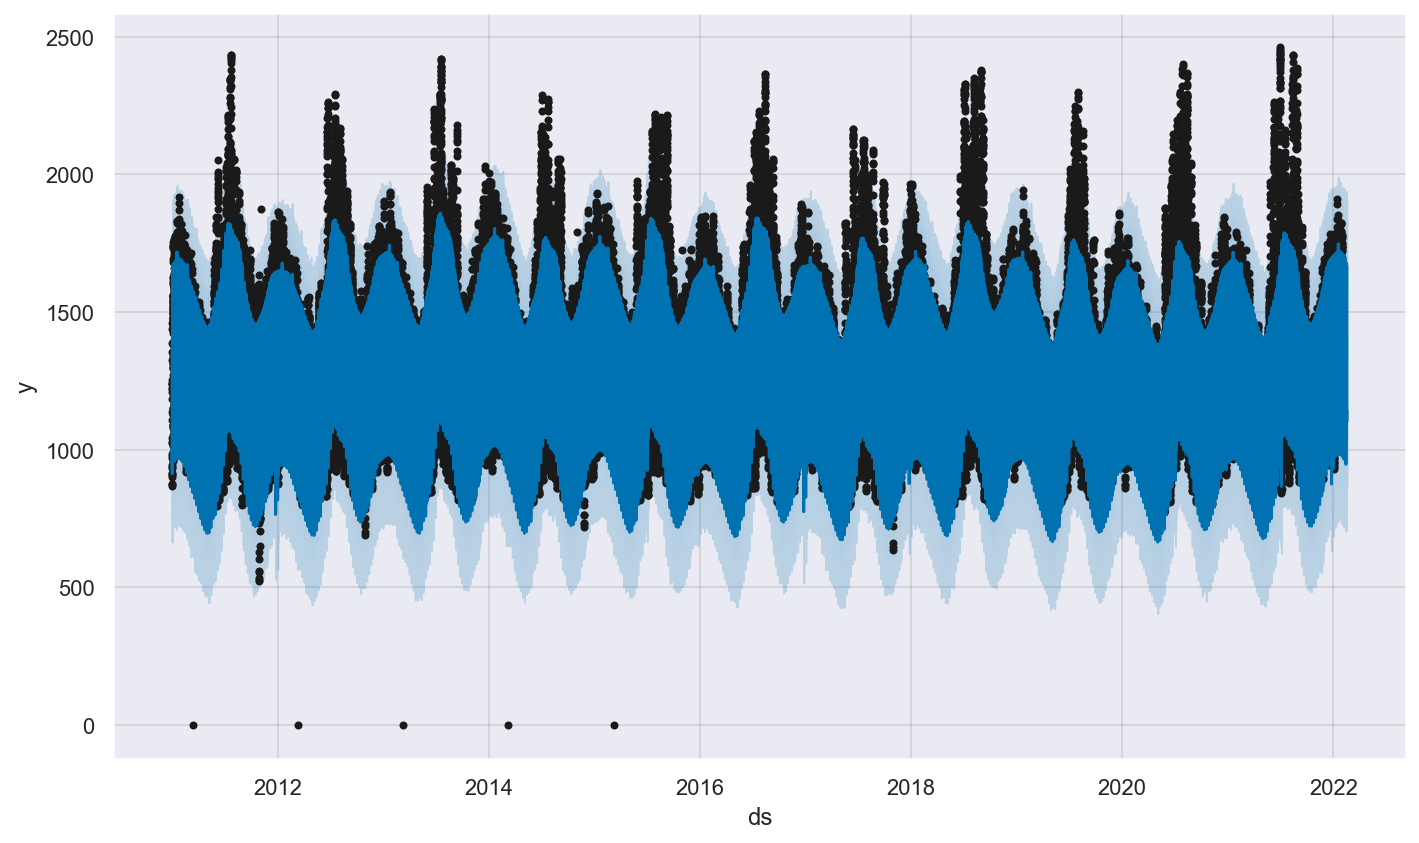

In [16]:
fig1 = model.plot(forecast_pd)

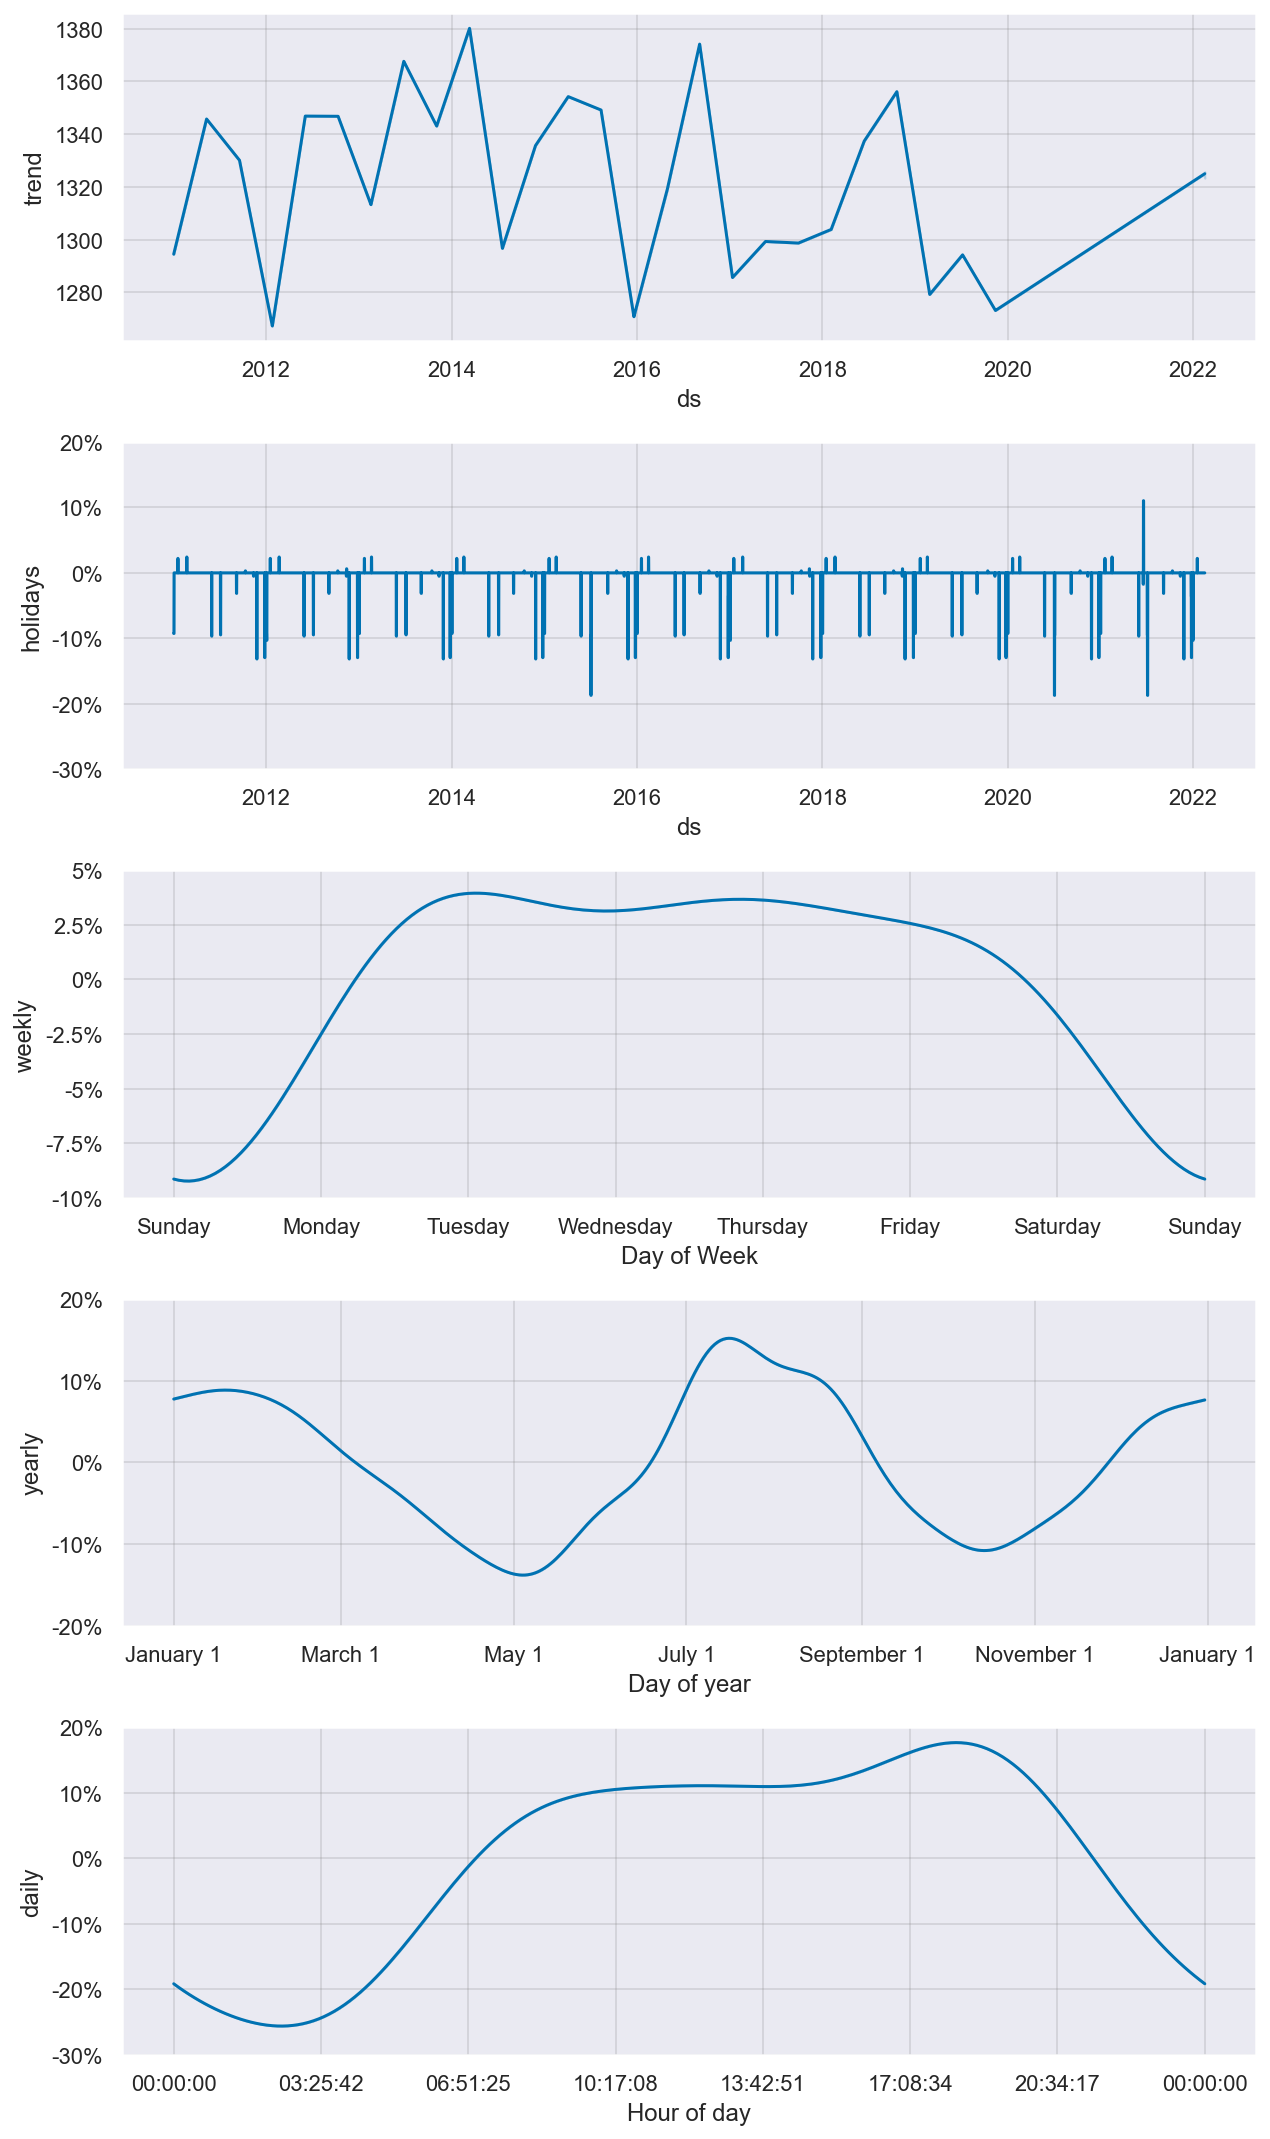

In [17]:
fig2 = model.plot_components(forecast_pd)

In [18]:
forecast_pd

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01 00:00:00,1294.464824,762.717816,1245.122122,1294.464824,1294.464824,0.0,0.0,0.0,0.0,...,-0.016421,-0.016421,-0.016421,0.077050,0.077050,0.077050,0.0,0.0,0.0,1004.772330
1,2011-01-01 01:00:00,1294.481304,715.767074,1185.583707,1294.481304,1294.481304,0.0,0.0,0.0,0.0,...,-0.019906,-0.019906,-0.019906,0.077085,0.077085,0.077085,0.0,0.0,0.0,949.124555
2,2011-01-01 02:00:00,1294.497785,671.710778,1172.831576,1294.497785,1294.497785,0.0,0.0,0.0,0.0,...,-0.023504,-0.023504,-0.023504,0.077120,0.077120,0.077120,0.0,0.0,0.0,916.183911
3,2011-01-01 03:00:00,1294.514265,663.599851,1164.131004,1294.514265,1294.514265,0.0,0.0,0.0,0.0,...,-0.027199,-0.027199,-0.027199,0.077156,0.077156,0.077156,0.0,0.0,0.0,911.812746
4,2011-01-01 04:00:00,1294.530746,713.950006,1180.907793,1294.530746,1294.530746,0.0,0.0,0.0,0.0,...,-0.030977,-0.030977,-0.030977,0.077191,0.077191,0.077191,0.0,0.0,0.0,946.155714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97536,2022-02-16 00:00:00,1324.972282,942.545640,1422.206265,1323.328733,1325.562142,0.0,0.0,0.0,0.0,...,0.031437,0.031437,0.031437,0.052808,0.052808,0.052808,0.0,0.0,0.0,1182.456664
97537,2022-02-16 01:00:00,1324.974901,907.896833,1384.216045,1323.325251,1325.614838,0.0,0.0,0.0,0.0,...,0.031560,0.031560,0.031560,0.052697,0.052697,0.052697,0.0,0.0,0.0,1130.074481
97538,2022-02-16 02:00:00,1324.977519,866.812437,1345.446334,1323.305062,1325.667534,0.0,0.0,0.0,0.0,...,0.031738,0.031738,0.031738,0.052587,0.052587,0.052587,0.0,0.0,0.0,1101.156882
97539,2022-02-16 03:00:00,1324.980138,875.165973,1348.514137,1323.284452,1325.720230,0.0,0.0,0.0,0.0,...,0.031966,0.031966,0.031966,0.052476,0.052476,0.052476,0.0,0.0,0.0,1101.677719


In [19]:
forecast_pd.to_csv('nh_forecast.csv', index=False)

In [20]:
import joblib
 
# Save the model as a pickle in a file
joblib.dump(model, 'nh_model.pkl')

['nh_model.pkl']